In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import nlopt
import statsmodels.api as sma
from statsmodels.regression.quantile_regression import QuantReg as qr

window_size = 10

# Đường dẫn đến file Excel
file_path_macro = 'MAcro-2018-2023.xlsx'
file_path_index = 'Dữ liệu Lịch sử VN Index.xlsx'
file_path_vni = 'vni.xlsx'
file_path_DE = 'FiinProX_DE_Doanh_nghiep_20231020.xlsx'

# Đọc file Excel vào DataFrame
skip_rows = [i for i in range(8, 18)] 
system = pd.read_excel(file_path_index)
df_macro = pd.read_excel(file_path_macro, header=7,skiprows=skip_rows, nrows=60)
df_vni = pd.read_excel(file_path_vni)
df_DE = pd.read_excel(file_path_DE, header=7, nrows=416)

In [2]:
df_macro['Ngày'] = pd.to_datetime(df_macro['Ngày'])

In [3]:
# Chuyển đổi cột 'Ngày' trong cả hai DataFrame về cùng định dạng datetime để thực hiện merge


system['Ngày'] = pd.to_datetime(system['Ngày'])
df_macro['Ngày'] = pd.to_datetime(df_macro['Ngày'])
system=system.groupby(pd.Grouper(key='Ngày', freq='MS')).tail(1)

system['Ngày'] = pd.to_datetime(system['Ngày'])
system.set_index('Ngày', inplace=True)

system.rename(columns={'% Thay đổi': 'MarketLoss'}, inplace=True)










C:\Users\chotr\AppData\Local\Temp\ipykernel_17020\3859072631.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  system['Ngày'] = pd.to_datetime(system['Ngày'])


In [4]:
system.index.name = None
system = system[['MarketLoss']]
system.index = system.index.to_period('M')
print(system)

         MarketLoss
2018-01     -0.0002
2018-02      0.0017
2018-03      0.0064
2018-04      0.0052
2018-05      0.0240
2018-06      0.0036
2018-07      0.0070
2018-08     -0.0085
2018-09      0.0017
2018-10      0.0293
2018-11     -0.0003
2018-12     -0.0092
2019-01     -0.0057
2019-02     -0.0250
2019-03     -0.0023
2019-04      0.0057
2019-05     -0.0098
2019-06      0.0072
2019-07      0.0057
2019-08      0.0056
2019-09     -0.0013
2019-10     -0.0021
2019-11      0.0004
2019-12     -0.0042
2020-01     -0.0239
2020-02     -0.0181
2020-03      0.0004
2020-04      0.0025
2020-05      0.0036
2020-06     -0.0051
2020-07     -0.0034
2020-08      0.0030
2020-09      0.0014
2020-10      0.0070
2020-11     -0.0071
2020-12      0.0058
2021-01      0.0319
2021-02      0.0026
2021-03      0.0043
2021-04      0.0080
2021-05      0.0057
2021-06     -0.0011
2021-07      0.0127
2021-08      0.0025
2021-09      0.0021
2021-10      0.0044
2021-11     -0.0043
2021-12      0.0083
2022-01      0.0056


In [5]:
stateVariables_M = df_macro.sort_values('Ngày', ascending=False)
stateVariables_M = stateVariables_M.drop(columns='Lãi suất trái phiếu chính phủ 1 năm\nĐơn vị:')
stateVariables_M = stateVariables_M.drop(columns='Lãi suất trái phiếu chính phủ 10 năm\nĐơn vị: %')
stateVariables_M['Ngày'] = pd.to_datetime(stateVariables_M['Ngày'])
stateVariables_M.set_index('Ngày', inplace=True)
stateVariables_M = stateVariables_M.drop(columns='STT')
stateVariables_M = stateVariables_M.drop(columns='Kỳ')
stateVariables_M = stateVariables_M.drop(columns='market return\nvì data vĩ mô theo tháng nên phải lọc data VNI theo tháng luôn :')
stateVariables_M.index.name = None
stateVariables_M = stateVariables_M.sort_index(ascending=True)
stateVariables_M.index = stateVariables_M.index.to_period('M')
print(stateVariables_M)

               M2     INF     CPI  \
2018-01   8296475  0.0118  0.0265   
2018-02   8401534  0.0147  0.0315   
2018-03   8521098  0.0138  0.0266   
2018-04   8661255  0.0133  0.0275   
2018-05   8757588  0.0137  0.0386   
2018-06   8879582  0.0137  0.0467   
2018-07   8842552  0.0141  0.0446   
2018-08   8888384  0.0154  0.0398   
2018-09   8933435  0.0161  0.0398   
2018-10   8999033  0.0167  0.0389   
2018-11   9061689  0.0172  0.0346   
2018-12   9211848  0.0170  0.0298   
2019-01   9488086  0.0183  0.0256   
2019-02   9376631  0.0182  0.0264   
2019-03   9478157  0.0184  0.0270   
2019-04   9546608  0.0188  0.0293   
2019-05   9706888  0.0190  0.0288   
2019-06   9866484  0.0196  0.0216   
2019-07   9860081  0.0204  0.0244   
2019-08   9949135  0.0195  0.0226   
2019-09  10083735  0.0196  0.0198   
2019-10  10138630  0.0199  0.0224   
2019-11  10274960  0.0218  0.0352   
2019-12  10573725  0.0278  0.0523   
2020-01  10758024  0.0325  0.0643   
2020-02  10672880  0.0294  0.0540   
2

In [6]:





stocks_losses= df_vni
stocks_losses['date'] = pd.to_datetime(df_vni['date'])
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2022-12-31')
stocks_losses = stocks_losses[(stocks_losses['date'] >= start_date) & (df_vni['date'] <= end_date)]

stocks_losses.set_index('date', inplace=True)
stocks_losses= stocks_losses.resample('M').last()

tickers = df_DE['Mã'].unique()

stocks_losses = stocks_losses[stocks_losses.columns.intersection(tickers)]
stocks_losses.index.name = None
stocks_losses_D_pct=stocks_losses
stocks_losses_D_pct.index = stocks_losses_D_pct.index.to_period('M')


print(stocks_losses_D_pct)










           AAA    ACB    APG    CTS    CVT    DBC    DBT    DC4    FIT    NHA  \
2018-01  29.90  41.70   5.95  14.00  47.70  28.00  15.70   9.60   7.38  11.30   
2018-02  28.20  47.00   6.10  13.25  43.70  26.60  15.30  12.00   6.48  11.00   
2018-03  24.80  46.70   5.56  13.95  51.10  22.50  16.40  11.40   6.65  12.00   
2018-04  20.00  42.40   5.58  13.50  46.50  20.70  14.60  10.70   5.70  11.10   
2018-05  20.20  40.00   5.64  12.20  29.40  22.30  12.70   9.70   5.00   9.00   
2018-06  18.90  35.60   5.64  10.85  27.90  22.00  13.10  10.30   4.44   9.20   
2018-07  17.15  35.80   5.17  11.60  25.70  25.00  12.80  10.60   4.23   8.90   
2018-08  17.80  39.10   5.20  11.60  26.30  28.30  13.00  11.90   4.05   7.90   
2018-09  17.50  34.10   6.94  12.55  28.60  29.30  12.90  10.10   4.15   7.60   
2018-10  14.60  30.30   7.20  12.00  23.00  28.00  13.00  11.00   3.33   8.40   
2018-11  14.85  29.80   7.18  10.20  22.10  26.20  13.00  10.00   2.78   7.80   
2018-12  14.70  29.60   7.87

In [7]:
#In [34]
def historical_var(stock_name, q, window_size = window_size, stocks_losses_series = stocks_losses_D_pct ):
    return stocks_losses_series[stock_name].dropna().rolling(
        window = window_size, min_periods = int(0.8 * window_size)
    ).apply(lambda x: np.quantile(x, q)).dropna().rename(stock_name + "_VaR_" + str(q))

#In [35]
def formula_var(stock_name, q, window_size = window_size, stocks_losses_series = stocks_losses_D_pct ):
    rolling = stocks_losses_series[stock_name].dropna().rolling(window = window_size, min_periods = int(0.8 * window_size))
    mean_series = rolling.mean()
    std_series = rolling.std()
    return (mean_series + stats.norm.ppf(q) * std_series).dropna().rename(stock_name + "_VaR_" + str(q))

def Trs(df):
    return np.array(df.T)[0]

def regularize(series_i, market_losses_series, state_variables_series):
    series_i = series_i.dropna().copy()
    mkt = market_losses_series.copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()
    common = svs_lagged.index.intersection(series_i.index)
    mkt = mkt.loc[common,:]
    series_i = series_i.loc[common]
    svs_lagged = svs_lagged.loc[common,:]
    return series_i, mkt, svs_lagged
def log_likelihood_norm(params, series_i, mkt, svs_lagged):
    pi = math.pi
    n = series_i.shape[0]
    num_state_vars = svs_lagged.shape[1]
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6][:num_state_vars])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6][:num_state_vars])

    part1 = (-n) * np.log(sigma)
    part2 = (-n / 2) * np.log(2 * pi)
    part3 = (-1.0 / 2 / np.power(sigma, 2)) * (sum(np.power(
            mu - (Trs(mkt) - p0 - p1_v.dot(svs_lagged.T) - p2 * Trs(series_i))
                / (p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)), 2)))
    ll = part1 + part2 + part3
    return ll
def fit_mle_norm(series_i, mkt, svs_lagged, initial_guess = None):

    def mle_objective(temp, grad):
        assert len(grad) == 0
        assert len(temp) == 20
        return -log_likelihood_norm(temp, series_i, mkt, svs_lagged)

    lb = [-10, 0] + [-10] + [-1, -5, -0.3, -6, -4, -3, -10] + [-5, -10] + [-1, -5, -0.3, -6, -4, -3, -10] + [-5]
    ub = [10, 10] + [10] + [1, 5, 0.3, 6, 4, 3, 10] + [5, 10] + [1, 5, 0.3, 6, 4, 3, 10] + [5]
    opt = nlopt.opt(nlopt.LN_COBYLA, 20)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_min_objective(mle_objective)
    opt.set_xtol_rel(1e-2)
    opt.set_ftol_abs(1e-3)

    if initial_guess is None:
        x0 = [0.2] * 20
    else:
        x0 = initial_guess
    x = opt.optimize(x0)

    assert opt.last_optimize_result() in [nlopt.SUCCESS, nlopt.FTOL_REACHED, nlopt.XTOL_REACHED]
    # print(x)
    return x

def MLE_var_result(params, stock_name, q, series_i, mkt, svs_lagged):
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6])

    loc_series = p0 + p1_v.dot(svs_lagged.T) + p2 * Trs(series_i)
    scale_series = p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)
    err_series = (Trs(mkt) - loc_series) / scale_series
    var_series = []
    for i in range(err_series.shape[0]):
        var_series.append(stats.norm(loc_series[i] + mu * scale_series[i], scale_series[i] * sigma).ppf(q))
    loc_series = pd.Series(loc_series, index = mkt.index, name = "loc")
    scale_series = pd.Series(scale_series, index = mkt.index, name = "scale")
    var_series = pd.Series(var_series, index = mkt.index, name = stock_name + "_VaR_" + str(q))
    error_series = pd.Series(err_series, index = mkt.index, name = "error_term")
    return var_series, (mu, sigma), pd.concat([var_series, error_series, loc_series, scale_series], axis = 1)

def MLE_var(stock_name, q,
            market_losses_series = system,
            stocks_losses_series = stocks_losses_D_pct ,
            state_variables_series = stateVariables_M):

    stk, mkt, svs_lagged = regularize(stocks_losses_series[stock_name], market_losses_series, state_variables_series)
    params = fit_mle_norm(stk, mkt, svs_lagged)
    return MLE_var_result(params, stock_name, q, stk, mkt, svs_lagged)

def qr_var(stock_name, q, modified = True,
           state_variables_series = stateVariables_M,
           stocks_losses_series = stocks_losses_D_pct ):

    stk = stocks_losses_series[stock_name].dropna().copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()
    if modified:
        stk_lagged = stk.shift(1).dropna()
        common = stk_lagged.index.intersection(svs_lagged.index)
        stk = stk.loc[common]
        reg = svs_lagged.loc[common,:]
        reg["stock_lagged"] = stk_lagged.loc[common]
    else:
        common = stk.index.intersection(svs_lagged.index)
        stk = stk.loc[common]
        reg = svs_lagged.loc[common,:]

    qr_model = qr(stk, sma.add_constant(reg)).fit(q)
    qr_var_values = qr_model.fittedvalues.rename(stock_name + "_VaR_" + str(q))
    return qr_var_values, qr_model

def var(stock_name, q, qr_var_method, qr_var_modified = True):
    if qr_var_method != qr_var and qr_var_modified == False:
        raise Exception("Input Error! Only Quantile Regression VaR model can be modified!")
    if qr_var_method == qr_var:
        if qr_var_modified:
            stk_var = qr_var_method(stock_name, q)[0]
        else:
            stk_var = qr_var_method(stock_name, q, modified = False)[0]
    elif qr_var_method == MLE_var:
        stk_var = qr_var_method(stock_name, q)[0]
    else:
        stk_var = qr_var_method(stock_name, q)
    return stk_var

def qr_covar(stock_name, q, qr_var_method, qr_var_modified = True,
             state_variables_series = stateVariables_M,
             market_losses_series = system):

    stk_var = var(stock_name, q, qr_var_method, qr_var_modified)
    mkt = market_losses_series.copy()
    svs_lagged = state_variables_series.copy().shift(1).dropna()

    common = svs_lagged.index.intersection(stk_var.index)
    mkt = mkt.loc[common,:]
    reg = svs_lagged.loc[common,:]
    reg[stk_var.name] = stk_var.loc[common]

    qr_model = qr(mkt, sma.add_constant(reg)).fit(q)
    qr_covar_values = qr_model.fittedvalues.rename(stock_name + "_CoVaR_" + str(q))

    return qr_covar_values, qr_model, stk_var

def qr_delta_covar(stock_name, q, qr_var_method, qr_var_modified = True,
                   formula_alter = True):

    if q <= 0.5 and q >= 1:
        raise Exception("Input Error! q should be in (0.5, 1)!")

    if formula_alter:
        _, qr_model_q, stk_var = qr_covar(stock_name, q, qr_var)
        var_median = qr_covar(stock_name, 0.5, qr_var)[2]
        return ((stk_var - var_median) * qr_model_q.params[-1]).rename(stock_name + "_\u0394CoVaR_" + str(q) + "_formula2"), stk_var
    else:
        covar_qr, _, stk_var = qr_covar(stock_name, q, qr_var)
        temp = covar_qr - qr_covar(stock_name, 0.5, qr_var)[0]
        return temp.rename(stock_name + "_\u0394CoVaR_" + str(q) + "_formula1"), stk_var
    
def MLE_covar_result(params, stock_name, q, series_i, mkt, svs_lagged):
    mu, sigma, p0, p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6, p2, p3, p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6, p5 = params
    p1_v = np.array([p1_0, p1_1, p1_2, p1_3, p1_4, p1_5, p1_6])
    p4_v = np.array([p4_0, p4_1, p4_2, p4_3, p4_4, p4_5, p4_6])

    loc_series = p0 + p1_v.dot(svs_lagged.T) + p2 * Trs(series_i)
    scale_series = p3 + p4_v.dot(svs_lagged.T) + p5 * Trs(series_i)
    err_series = (Trs(mkt) - loc_series) / scale_series
    covar_series = []
    for i in range(err_series.shape[0]):
        covar_series.append(stats.norm(loc_series[i] + mu * scale_series[i], scale_series[i] * sigma).ppf(q))
    loc_series = pd.Series(loc_series, index = mkt.index, name = "loc")
    scale_series = pd.Series(scale_series, index = mkt.index, name = "scale")
    covar_series = pd.Series(covar_series, index = mkt.index, name = stock_name + "_CoVaR_" + str(q))
    error_series = pd.Series(err_series, index = mkt.index, name = "error_term")
    return covar_series, (mu, sigma), pd.concat([covar_series, error_series, loc_series, scale_series], axis = 1)

def MLE_covar(stock_name, q, qr_var_method, qr_var_modified = True,
              state_variables_series = stateVariables_M,
              market_losses_series = system):

    stk_var = var(stock_name, q, qr_var_method, qr_var_modified)
    var_i, mkt, svs_lagged = regularize(stk_var, market_losses_series, state_variables_series)
    params = fit_mle_norm(var_i, mkt, svs_lagged)
    return MLE_covar_result(params, stock_name, q, var_i, mkt, svs_lagged)
def MLE_delta_covar(stock_name, q, qr_var_method, qr_var_modified = True):
    if q <= 0.5 and q >= 1:
        raise Exception("Input Error! q should be in (0.5, 1)!")
    covar_MLE, stk_var = MLE_covar(stock_name, q, qr_var_method, qr_var_modified)[:2]
    temp = covar_MLE - MLE_covar(stock_name, 0.5, qr_var_method, qr_var_modified)[0]
    return temp.rename(stock_name + "_\u0394CoVaR_" + str(q)), stk_var
def var_params_MLE(stock_name, 
              market_losses_series = system, 
              stocks_losses_series = stocks_losses_D_pct , 
              state_variables_series = stateVariables_M):
    stk, mkt, svs_lagged = regularize(stocks_losses_series[stock_name], market_losses_series, state_variables_series)
    return fit_mle_norm(stk, mkt, svs_lagged), stk, mkt, svs_lagged

In [8]:

max_values = pd.DataFrame(columns = ["Max_Params", "Test_Params"])
params = pd.DataFrame(columns = list(stocks_losses_D_pct.columns))

for stock_name in list(stocks_losses_D_pct.columns):
    params[stock_name], stk, mkt, svs_lagged = var_params_MLE(stock_name)
    test_params = params[stock_name].copy()
    test_params[:] = [3, 1, 0, 0.3, -2, -0.2, 4, -2, -1, -9, 4, 8, -0.7, 1, 0.1, -2, 1, 2, 7, 3]
    max_values.loc[stock_name, "Max_Params"] = log_likelihood_norm(params[stock_name], stk, mkt, svs_lagged)
    max_values.loc[stock_name, "Test_Params"] = log_likelihood_norm(test_params, stk, mkt, svs_lagged)

In [9]:
params

,AAA,ACB,APG,CTS,CVT,DBC,DBT,DC4,FIT,NHA,...,MIG,NHH,LPB,NHT,CTR,BCM,GVR,PGV,ABR,EVF
0,-0.311352,-0.316366,-0.321067,-0.316394,-0.316369,-0.298923,-0.298924,-0.303499,-0.316399,-0.285629,...,-0.325142,-0.316338,-0.294959,-0.321048,-0.311353,-0.302317,-0.320364,-0.300937,-0.281257,-0.321052
1,0.282990,0.282609,0.255218,0.282609,0.282609,0.281817,0.281816,0.282875,0.282609,0.282413,...,0.232603,0.282609,0.262959,0.238341,0.282990,0.245536,0.249306,0.245184,0.275834,0.262500
2,-2.131518,-2.107059,-2.300011,-2.107086,-2.107062,-2.124106,-2.124120,-2.146339,-2.107091,-2.107319,...,-2.107443,-2.107033,-2.237661,-2.096847,-2.131519,-2.348766,-2.124105,-2.104093,-2.228476,-2.234426
3,0.228476,0.228965,0.229069,0.228966,0.228965,0.229914,0.229913,0.227623,0.228966,0.228987,...,0.228501,0.228964,0.228100,0.230408,0.228476,0.238045,0.232873,0.231827,0.235519,0.229773
4,-0.194384,-0.191456,-0.160956,-0.191440,-0.191454,-0.200351,-0.200353,-0.186604,-0.191437,-0.202907,...,-0.162094,-0.191471,-0.190142,-0.232927,-0.194384,-0.187010,-0.188056,-0.225114,-0.187484,-0.218740
5,0.198559,0.198333,0.201416,0.198333,0.198333,0.198336,0.198336,0.197866,0.198333,0.197942,...,0.199122,0.198334,0.198175,0.198442,0.198559,0.197448,0.201362,0.199964,0.198059,0.196769
6,-0.458979,-0.464041,-0.505841,-0.464016,-0.464038,-0.466377,-0.466374,-0.441504,-0.464011,-0.461880,...,-0.415509,-0.464065,-0.460549,-0.437786,-0.458977,-0.497558,-0.368493,-0.493864,-0.464833,-0.426813
7,-0.084818,-0.076464,-0.039768,-0.076449,-0.076462,-0.057252,-0.057251,-0.074990,-0.076447,-0.070290,...,-0.011404,-0.076478,-0.056162,-0.063357,-0.084818,-0.039298,-0.124473,-0.129745,-0.090698,-0.044870
8,-0.487346,-0.474537,-0.446855,-0.474538,-0.474537,-0.478259,-0.478258,-0.473100,-0.474538,-0.473718,...,-0.415479,-0.474537,-0.447787,-0.455957,-0.487346,-0.476611,-0.476015,-0.523142,-0.473720,-0.490078
9,-0.050669,-0.034656,-0.005238,-0.034598,-0.034650,-0.023161,-0.023145,-0.033113,-0.034586,-0.000993,...,-0.055193,-0.034714,0.003497,-0.140166,-0.050664,-0.121722,-0.201913,0.111532,-0.053899,0.060800


In [10]:

max_values
False in (max_values["Max_Params"] > max_values["Test_Params"])

False

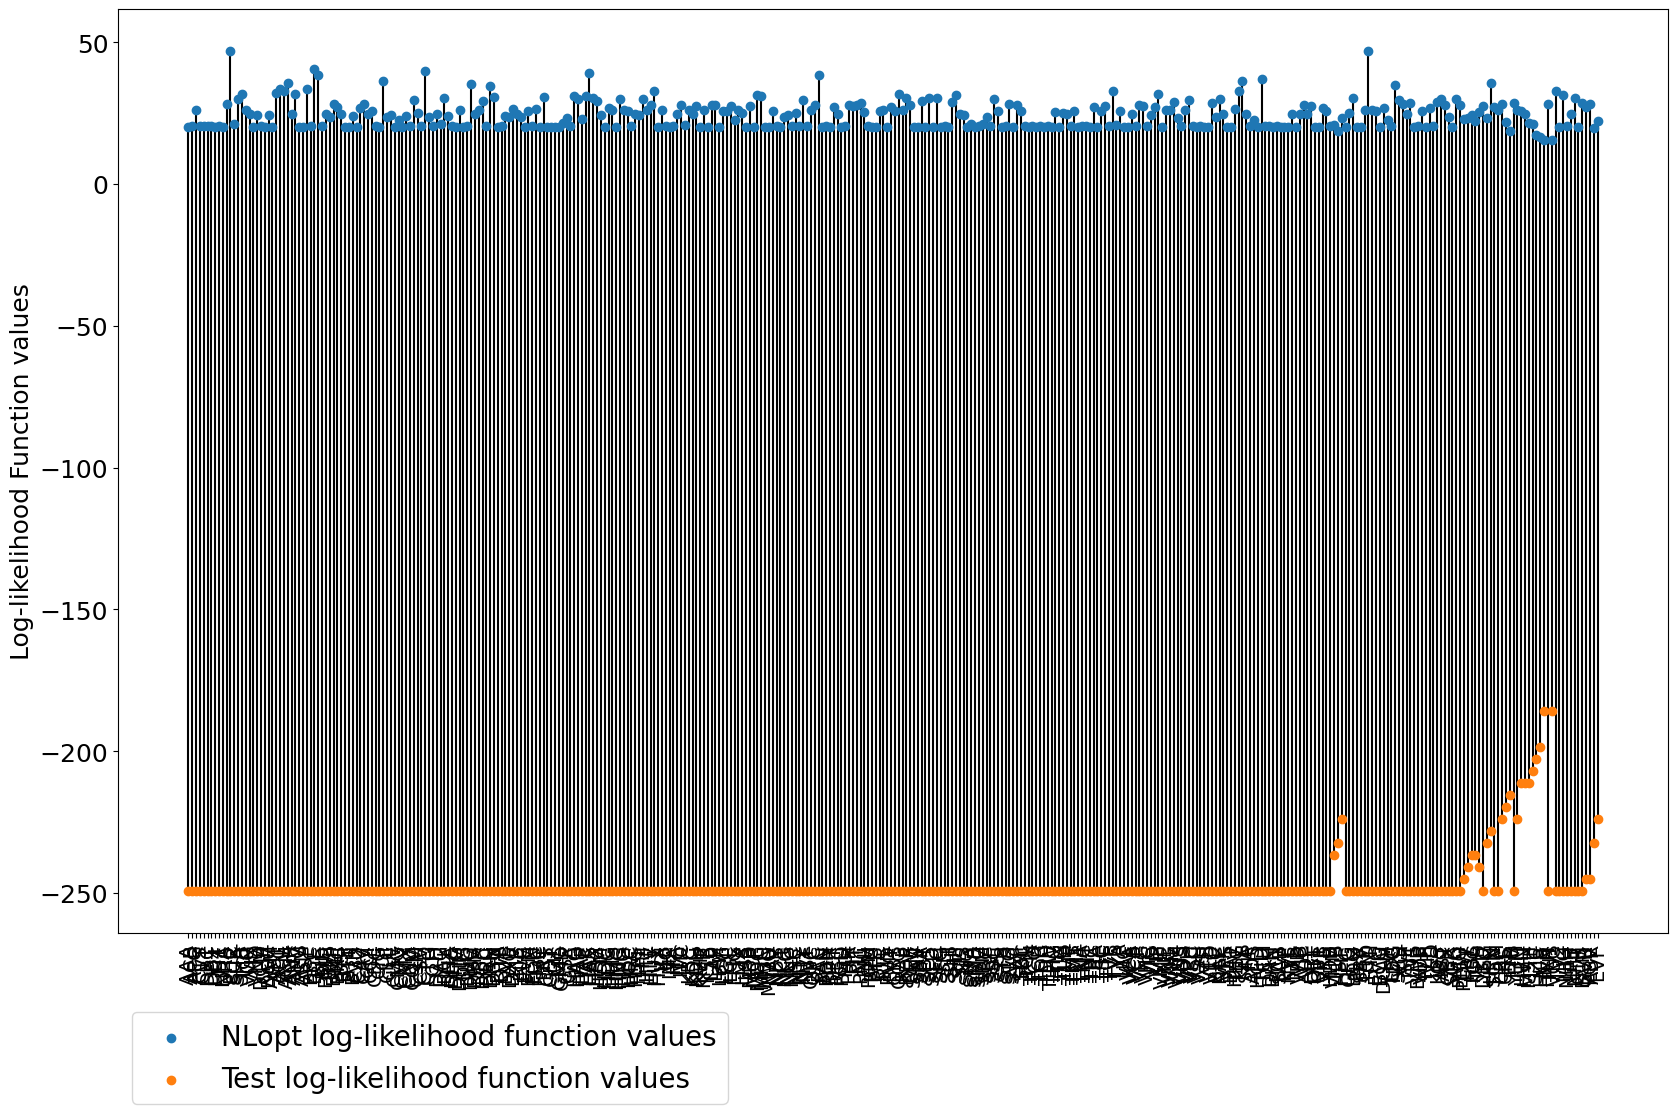

In [11]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
threshold = -6000
max_vec = max_values[max_values["Test_Params"] >= threshold].loc[:, "Max_Params"]
test_vec = max_values[max_values["Test_Params"] >= threshold].loc[:, "Test_Params"]
for i in range(max_vec.shape[0]):
    y = np.linspace(test_vec.iloc[i], max_vec.iloc[i], 100)
    ax1.plot([max_vec.index[i]] * 100, y, color = "k", zorder = 1)
ax1.scatter(max_vec.index, max_vec, zorder = 2, label = "NLopt log-likelihood function values")
ax1.scatter(test_vec.index, test_vec, zorder = 2, label = "Test log-likelihood function values")
plt.xticks(fontsize=14, rotation = 90)
plt.yticks(fontsize=18)
plt.ylabel("Log-likelihood Function values", fontsize=18)
plt.legend(bbox_to_anchor=(0,-0.2), loc="lower left", fontsize=20)

In [12]:
# Load S&P 500 Sector Information
sector = pd.read_excel("FiinProX_DE_Doanh_nghiep_20231020.xlsx", index_col = 0, header=7, nrows=416)
print("Number of stocks in S&P500: %d" % sector.shape[0])
# Make some necessary changes

sector=sector.set_index('Mã')
sector.index.name = None


Number of stocks in S&P500: 416


In [13]:
def var_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    historical = var(stock_name, q, historical_var)
    # print(historical)
    historical.index = historical.index.to_timestamp()
    formula = var(stock_name, q, formula_var)
    qr_author = var(stock_name, q, qr_var, False)[int(window_size * 0.8):]
    qr_modified = var(stock_name, q, qr_var)[int(window_size * 0.8):]
    plot_min = np.array([historical.min(),formula.min(),qr_author.min(),qr_modified.min()]).min() - 5
    plot_max = np.array([historical.max(),formula.max(),qr_author.max(),qr_modified.max()]).max() + 35
    MLE = var(stock_name, q, MLE_var)[int(window_size * 0.8):]
    plt.title(sector[sector.index == stock_name]["Tên công ty"].values[0] + " - From " + sector[sector.index == stock_name]["Ngành"].values[0] , fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(historical, label=str(int(100 *q)) + '%VaR - Nonparametric method')
        ax.plot(formula, label=str(int(100 *q)) + '%VaR - Semiparametric method')
        ax.plot(qr_author, label=str(int(100 *q)) + '%VaR - Parametric method [Quantile Regression - Author]')
        ax.plot(qr_modified, alpha = 0.8, label=str(int(100 *q)) + '%VaR - Parametric method [Quantile Regression - Modified (Add lagged stock losses series)]')
        ax.plot(MLE, label=str(int(100 *q)) + '%VaR - Parametric method [MLE]')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(historical)
        ax.plot(formula)
        ax.plot(qr_author)
        ax.plot(qr_modified, alpha = 0.8)
        ax.plot(MLE)

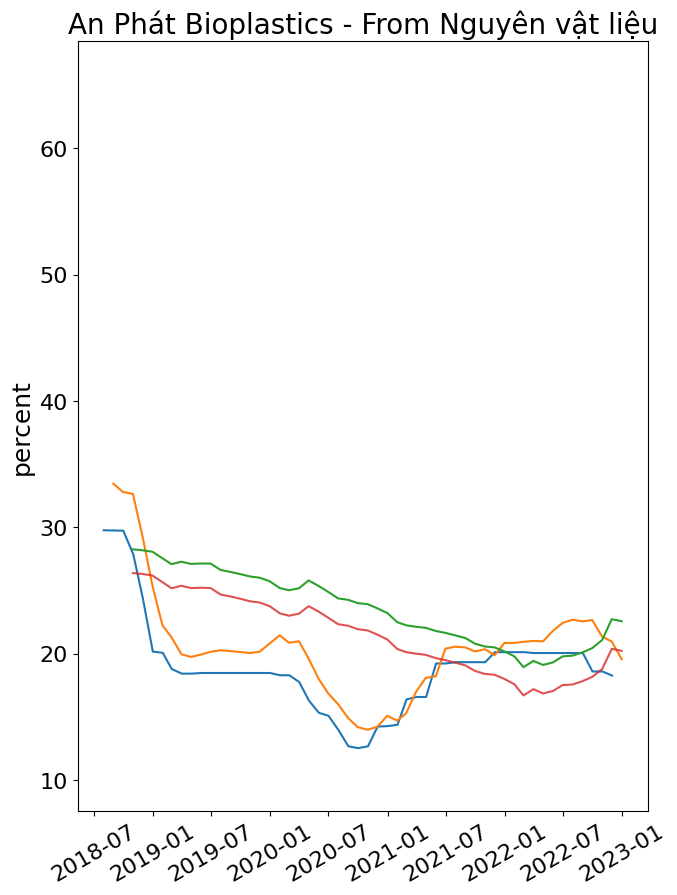

In [14]:
fig = plt.figure(figsize=(25, 22))
ax1 = fig.add_subplot(2, 3, 1)
var_plot("AAA", ax1)


In [15]:
def covar_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    MLE_MLE = MLE_covar(stock_name, q, MLE_var)[0]
    qr_MLE = MLE_covar(stock_name, q, qr_var)[0]
    qr_MLE.index = qr_MLE.index.to_timestamp()
    qr_qr = qr_covar(stock_name, q, qr_var)[0]
    MLE_qr = qr_covar(stock_name, q, MLE_var)[0]
    
    if q == 0.5:
        plot_min = np.array([qr_qr, MLE_qr]).min() - 3
        plot_max = np.array([qr_qr, MLE_qr]).max() + 10
    else:
        plot_min = np.array([qr_qr, MLE_qr]).min()
        plot_max = np.array([qr_qr, MLE_qr]).max() + 70

    plt.title(sector[sector.index == stock_name]["Tên công ty"].values[0] + " - From " + sector[sector.index == stock_name]["Ngành"].values[0] , fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(qr_MLE, label=str(int(100 *q)) + '%CoVaR - MLE - from ' + str(int(100 *q)) + '%VaR Quantile Regression')
        ax.plot(MLE_MLE, label=str(int(100 *q)) + '%CoVaR - MLE - from ' + str(int(100 *q)) + '%VaR MLE')
        ax.plot(qr_qr, label=str(int(100 *q)) + '%CoVaR - Quantile Regression - from ' + str(int(100 *q)) + '%VaR Quantile Regression')
        ax.plot(MLE_qr, label=str(int(100 *q)) + '%CoVaR - Quantile Regression - from ' + str(int(100 *q)) + '%VaR MLE')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(qr_MLE)
        ax.plot(MLE_MLE)
        ax.plot(qr_qr)
        ax.plot(MLE_qr)

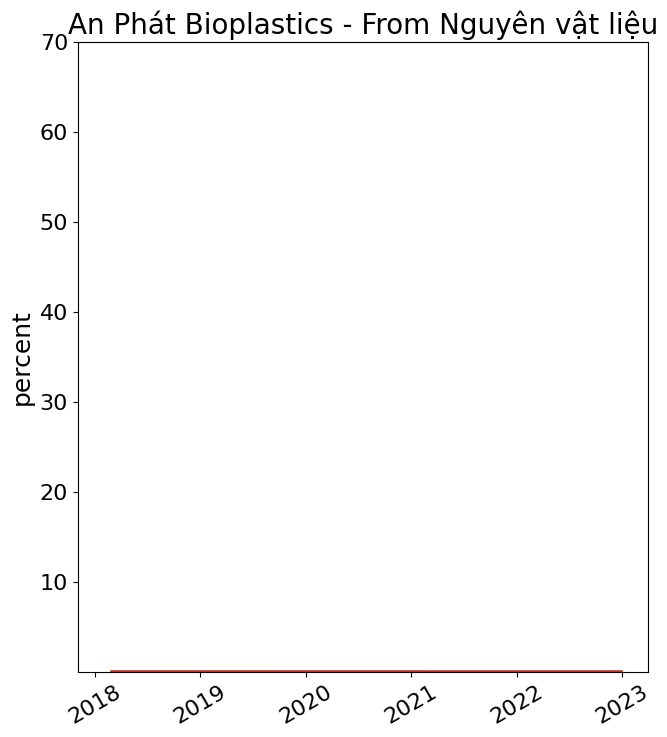

In [16]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 3, 1)
covar_plot("AAA", ax1)

c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


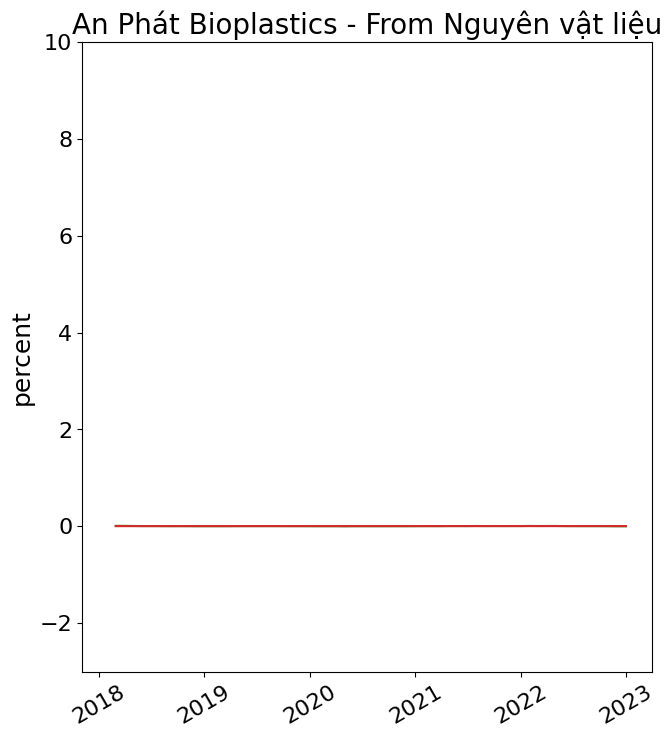

In [17]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 3, 1)
covar_plot("AAA", ax1, q = 0.5)

In [18]:
def delta_covar_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False):
    MLE_MLE = MLE_delta_covar(stock_name, q, MLE_var)[0]
    qr_MLE = MLE_delta_covar(stock_name, q, qr_var)[0]
    qr_qr_1 = qr_delta_covar(stock_name, q, qr_var, formula_alter = False)[0]
    qr_qr_2 = qr_delta_covar(stock_name, q, qr_var)[0]
    qr_qr_1.index = qr_qr_1.index.to_timestamp()

    if stock_name in ["GS", "ARE"]:
        plot_min = np.array([qr_qr_1]).min() - 15
        plot_max = np.array([qr_qr_1]).max() + 40
    elif stock_name == "AAPL":
        plot_min = np.array([qr_qr_2]).min() + 100
        plot_max = np.array([MLE_MLE]).max() - 50
    elif stock_name == "MMM":
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 30
    elif stock_name == "COP":
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 10
    else:
        plot_min = np.array([qr_qr_2]).min()
        plot_max = np.array([qr_qr_1]).max() + 60

    plt.title(sector[sector.index == stock_name]["Tên công ty"].values[0] + " - From " + sector[sector.index == stock_name]["Ngành"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.ylim(plot_min, plot_max)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(qr_qr_1, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula1 - from 99%VaR Quantile Regression')
        ax.plot(qr_qr_2, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula2 - from 99%VaR Quantile Regression')
        ax.plot(qr_MLE, label=str(int(100 *q)) + '%\u0394CoVaR - MLE - from 99%VaR Quantile Regression')
        ax.plot(MLE_MLE, label=str(int(100 *q)) + '%\u0394CoVaR - MLE - from 99%VaR MLE')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(qr_qr_1)
        ax.plot(qr_qr_2)
        ax.plot(qr_MLE)
        ax.plot(MLE_MLE)

c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


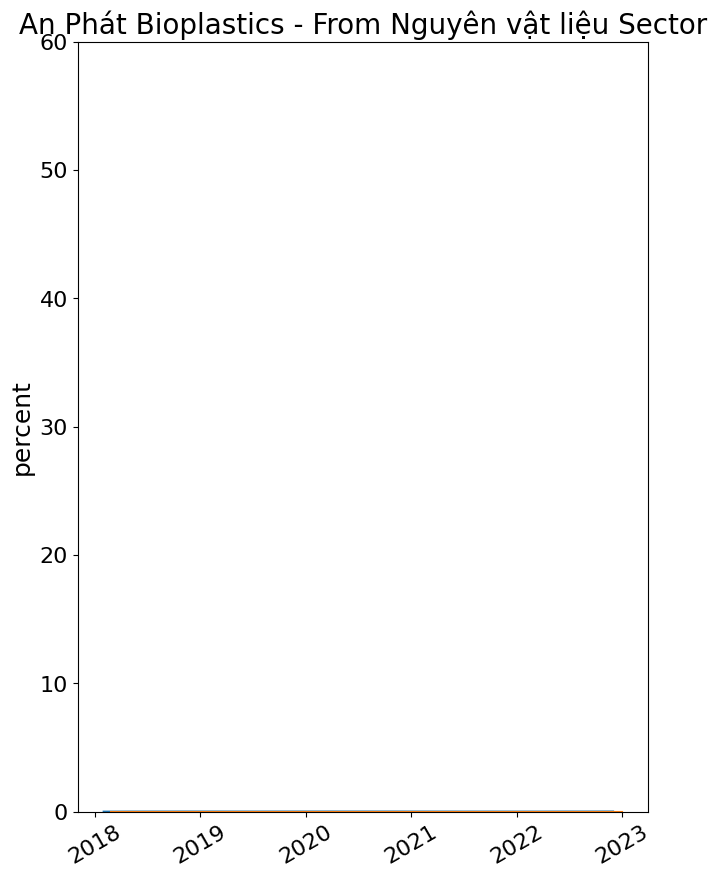

In [19]:
fig = plt.figure(figsize=(25, 22))
ax1 = fig.add_subplot(2, 3, 1)
delta_covar_plot("AAA", ax1)

In [20]:
def results_plot(stock_name, ax, q = 0.99, sector = sector, add_legend = False, market_losses_series = system):
    qr_modified = var(stock_name, q, qr_var)
    qr_qr = qr_delta_covar(stock_name, q, qr_var, formula_alter = False)[0]
    mkt = market_losses_series
    mkt.index = mkt.index.to_timestamp()
    var_series = qr_modified
    delta_covar_series = qr_qr

    plt.title(sector[sector.index == stock_name]["Tên công ty"].values[0] + " - From " + sector[sector.index == stock_name]["Ngành"].values[0] + " Sector", fontsize=20)
    plt.ylabel("percent", fontsize=18)
    plt.xticks(fontsize=16, rotation = 30)
    plt.yticks(fontsize=16)
    if add_legend:
        ax.plot(mkt, label='Market Equity Loss')
        ax.plot(var_series, label=str(int(100 *q)) + '%\u0394CoVaR - Quantile Regression - Formula1 - from 99%VaR Quantile Regression')
        ax.plot(delta_covar_series, label=str(int(100 *q)) + '%VaR - Quantile Regression - Modified (Add lagged stock losses series)')
        plt.legend(bbox_to_anchor=(0,-0.4), loc="lower left", fontsize=20)
    else:
        ax.plot(mkt)
        ax.plot(var_series)
        ax.plot(delta_covar_series)

c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


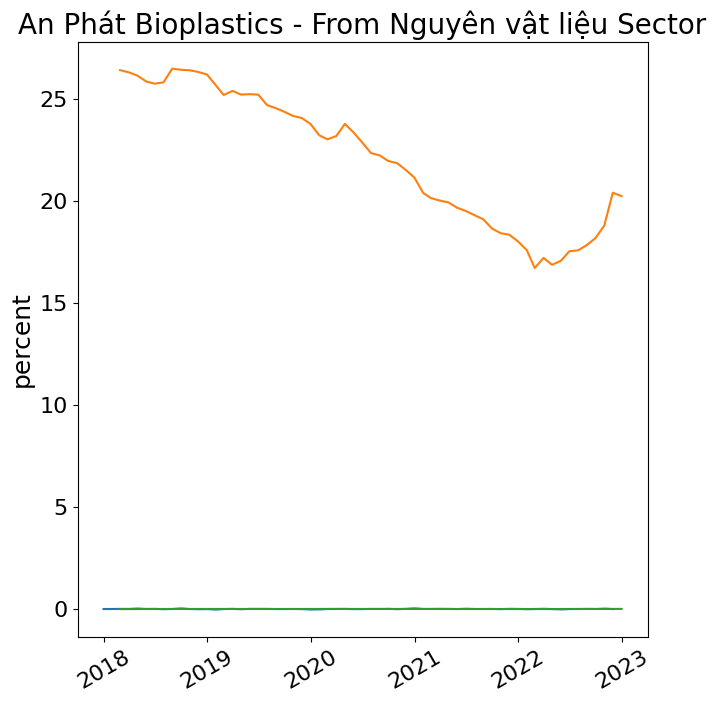

In [21]:
fig = plt.figure(figsize=(25, 17))
ax1 = fig.add_subplot(2, 3, 1)
results_plot("AAA", ax1)

In [22]:
system.index = system.index.to_period('M')
print(system)

         MarketLoss
2018-01     -0.0002
2018-02      0.0017
2018-03      0.0064
2018-04      0.0052
2018-05      0.0240
2018-06      0.0036
2018-07      0.0070
2018-08     -0.0085
2018-09      0.0017
2018-10      0.0293
2018-11     -0.0003
2018-12     -0.0092
2019-01     -0.0057
2019-02     -0.0250
2019-03     -0.0023
2019-04      0.0057
2019-05     -0.0098
2019-06      0.0072
2019-07      0.0057
2019-08      0.0056
2019-09     -0.0013
2019-10     -0.0021
2019-11      0.0004
2019-12     -0.0042
2020-01     -0.0239
2020-02     -0.0181
2020-03      0.0004
2020-04      0.0025
2020-05      0.0036
2020-06     -0.0051
2020-07     -0.0034
2020-08      0.0030
2020-09      0.0014
2020-10      0.0070
2020-11     -0.0071
2020-12      0.0058
2021-01      0.0319
2021-02      0.0026
2021-03      0.0043
2021-04      0.0080
2021-05      0.0057
2021-06     -0.0011
2021-07      0.0127
2021-08      0.0025
2021-09      0.0021
2021-10      0.0044
2021-11     -0.0043
2021-12      0.0083
2022-01      0.0056


In [23]:
var_series_vec = pd.DataFrame(columns = list(stocks_losses_D_pct.columns))
delta_covar_series_vec = pd.DataFrame(columns = list(stocks_losses_D_pct.columns))
for stock_name in list(stocks_losses_D_pct.columns):
    delta_covar_series_vec[stock_name], var_series_vec[stock_name] = qr_delta_covar(stock_name, 0.99, qr_var, formula_alter = False)


c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\chotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number

In [24]:
var_series_vec_corr = var_series_vec.copy()
delta_covar_series_vec_corr = delta_covar_series_vec.copy()
var_series_vec_corr["Market"] = system
delta_covar_series_vec_corr["Market"] = system

In [25]:
def print_model_summary(stock_name):
    print(qr_var(stock_name, 0.99)[1].summary())
    print(qr_covar(stock_name, 0.99, qr_var)[1].summary())

In [26]:
output_list = ["AAA", "ACB"]
for stock_name in output_list:
    print_model_summary(stock_name)

                         QuantReg Regression Results                          
Dep. Variable:                    AAA   Pseudo R-squared:              -0.2339
Model:                       QuantReg   Bandwidth:                         nan
Method:                 Least Squares   Sparsity:                          nan
Date:                Tue, 28 Nov 2023   No. Observations:                   59
Time:                        01:17:00   Df Residuals:                       50
                                        Df Model:                            8
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                    7.873e-08        nan        nan        nan         nan         nan
M2                                                       -1.79e-06        n

Sectors Analysis

In [27]:
sector_analyze1 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze1.loc["VaR",:] = var_series_vec.iloc[-1,:]
sector_analyze1.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-1,:]
for stock_name in list(sector_analyze1.columns):
    sector_analyze1.loc["Sector", stock_name] = sector.loc[stock_name, "Ngành"]

In [28]:
sector_analyze2 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze2.loc["VaR",:] = var_series_vec.iloc[-20,:]
sector_analyze2.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-20,:]
for stock_name in list(sector_analyze2.columns):
    sector_analyze2.loc["Sector", stock_name] = sector.loc[stock_name, "Ngành"]

In [29]:
sector_analyze3 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze3.loc["VaR",:] = var_series_vec.iloc[-40,:]
sector_analyze3.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-40,:]
for stock_name in list(sector_analyze3.columns):
    sector_analyze2.loc["Sector", stock_name] = sector.loc[stock_name, "Ngành"]

In [30]:
sector_analyze4 = pd.DataFrame(index = ["\u0394CoVaR", "VaR", "Sector"], columns = list(delta_covar_series_vec.columns))
sector_analyze4.loc["VaR",:] = var_series_vec.iloc[-45,:]
sector_analyze4.loc["\u0394CoVaR",:] = delta_covar_series_vec.iloc[-45,:]
for stock_name in list(sector_analyze4.columns):
    sector_analyze2.loc["Sector", stock_name] = sector.loc[stock_name, "Ngành"]

In [31]:
sector_names = list(set(sector.loc[:, "Ngành"]))

In [32]:
def scatter(stock_name, ax, sector_analyze):
    ax.scatter(sector_analyze.loc["VaR", stock_name], sector_analyze.loc["\u0394CoVaR", stock_name])

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,
         0.035,  0.04 ]),
 [Text(0, -0.005, '−0.005'),
  Text(0, 0.0, '0.000'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.009999999999999998, '0.010'),
  Text(0, 0.015, '0.015'),
  Text(0, 0.02, '0.020'),
  Text(0, 0.024999999999999998, '0.025'),
  Text(0, 0.030000000000000002, '0.030'),
  Text(0, 0.035, '0.035'),
  Text(0, 0.04, '0.040')])

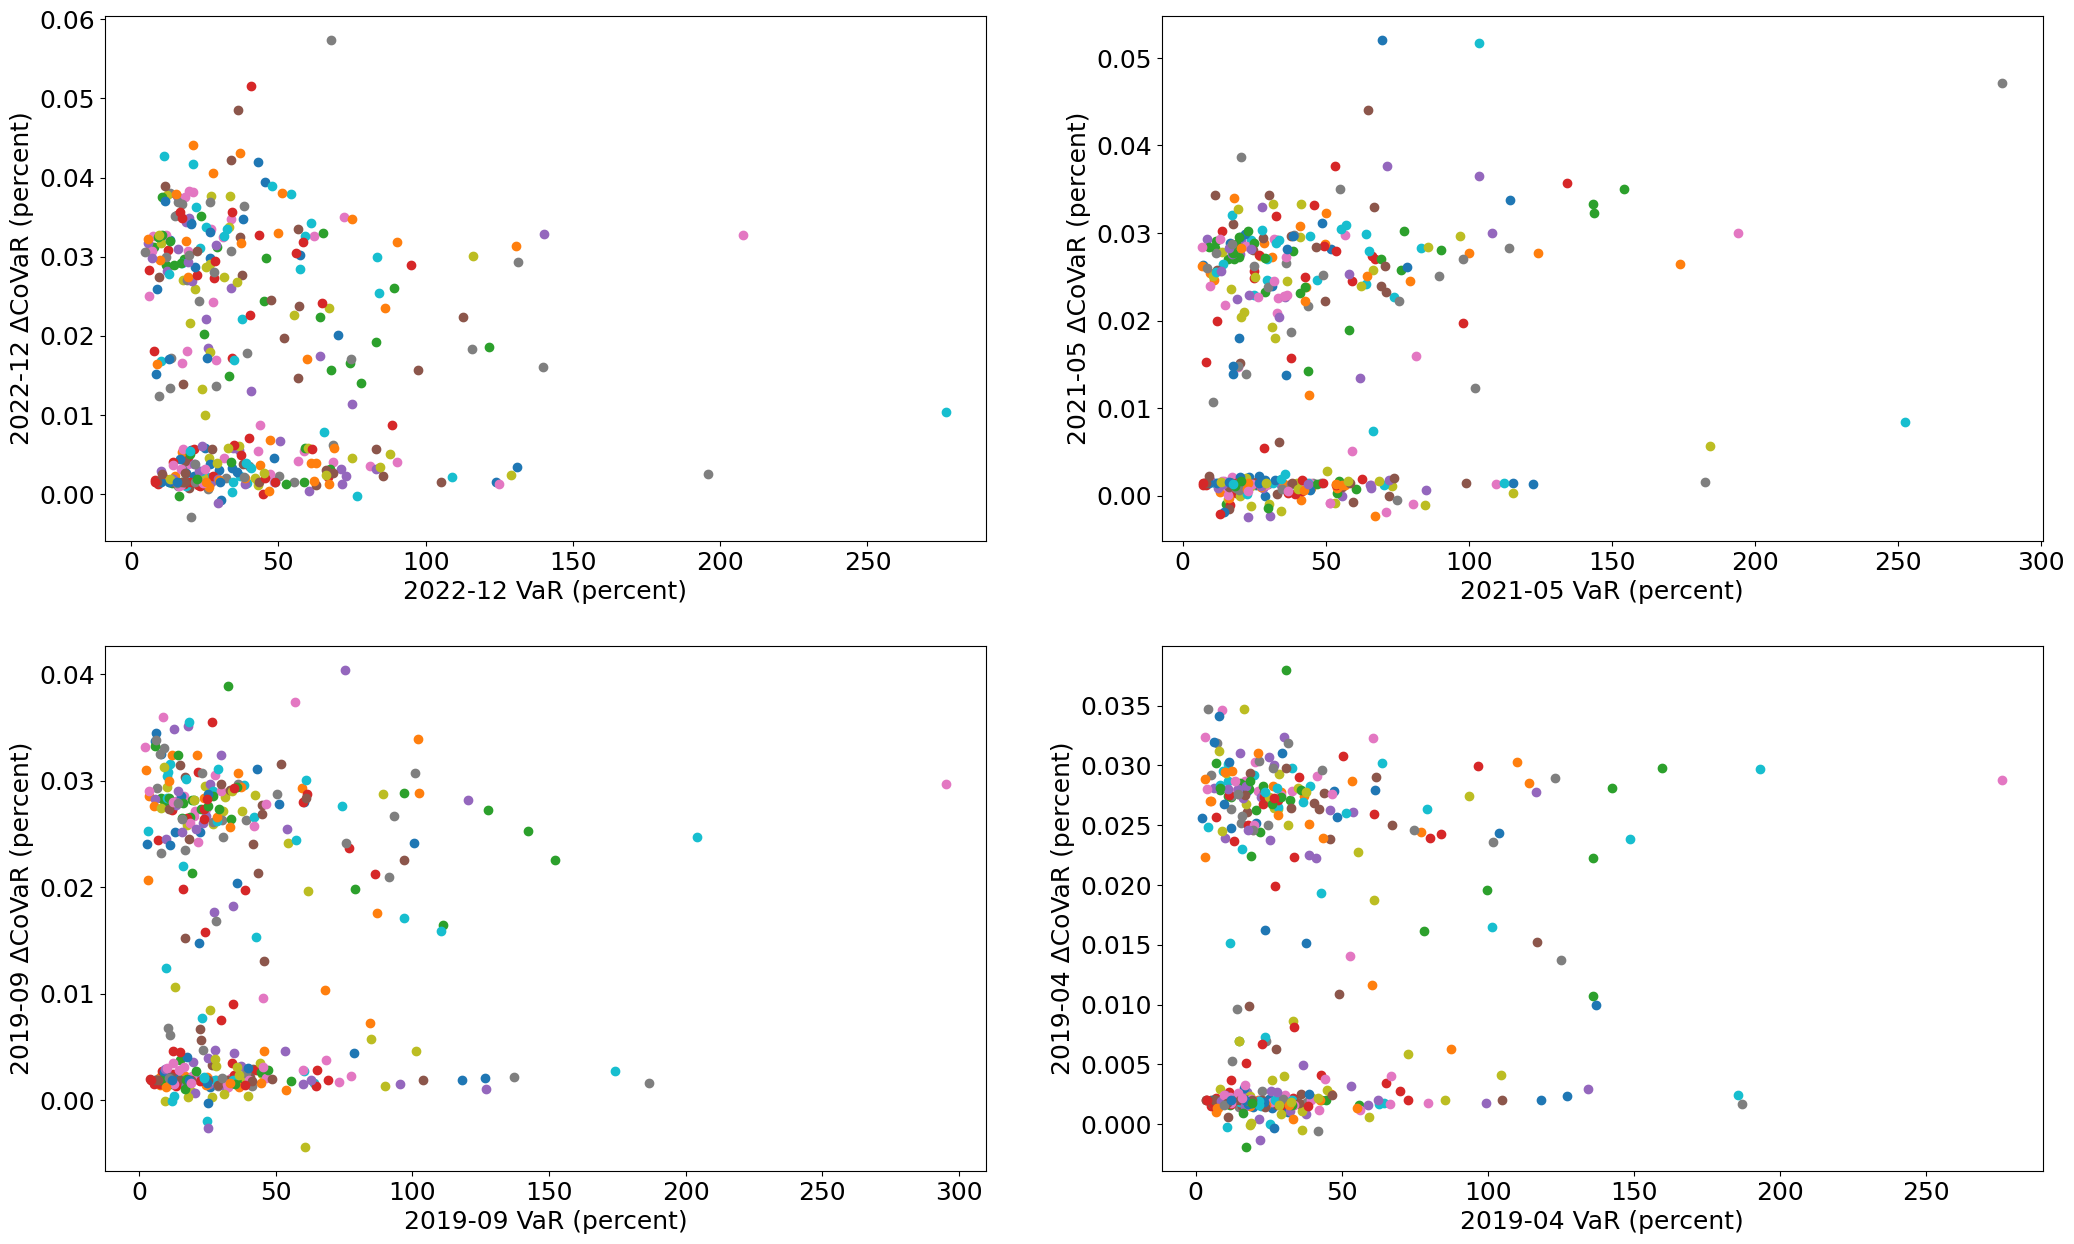

In [33]:
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(2, 2, 1)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax1, sector_analyze1)
ax1.set_ylabel(str(var_series_vec.iloc[-1,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax1.set_xlabel(str(var_series_vec.iloc[-1,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax2 = fig.add_subplot(2, 2, 2)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax2, sector_analyze2)
ax2.set_ylabel(str(var_series_vec.iloc[-20,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax2.set_xlabel(str(var_series_vec.iloc[-20,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax3, sector_analyze3)
ax3.set_ylabel(str(var_series_vec.iloc[-40,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax3.set_xlabel(str(var_series_vec.iloc[-40,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax4 = fig.add_subplot(2, 2, 4)
for i, stock_name in enumerate(list(delta_covar_series_vec.columns)):
    scatter(stock_name, ax4, sector_analyze4)
ax4.set_ylabel(str(var_series_vec.iloc[-45,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
ax4.set_xlabel(str(var_series_vec.iloc[-45,:].name)[:10] + " VaR (percent)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [34]:
def sector_plot(ax, j, sector_analyze, legend = False, sector_names = sector_names, v = var_series_vec):
    color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', "black"]
    for i, sector_name in enumerate(sector_names):
        temp = sector_analyze.loc[:, sector_analyze.loc["Sector",:] == sector_name]
        ax.scatter(temp.loc["VaR"], temp.loc["\u0394CoVaR"], color = color_list[i], label = sector_name)
        ax.set_ylabel(str(v.iloc[-j,:].name)[:10] + " \u0394CoVaR (percent)", fontsize=18)
        ax.set_xlabel(str(v.iloc[-j,:].name)[:10] + " VaR (percent)", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if legend:
            plt.legend(bbox_to_anchor=(0,-0.9), loc="lower left", fontsize=20)

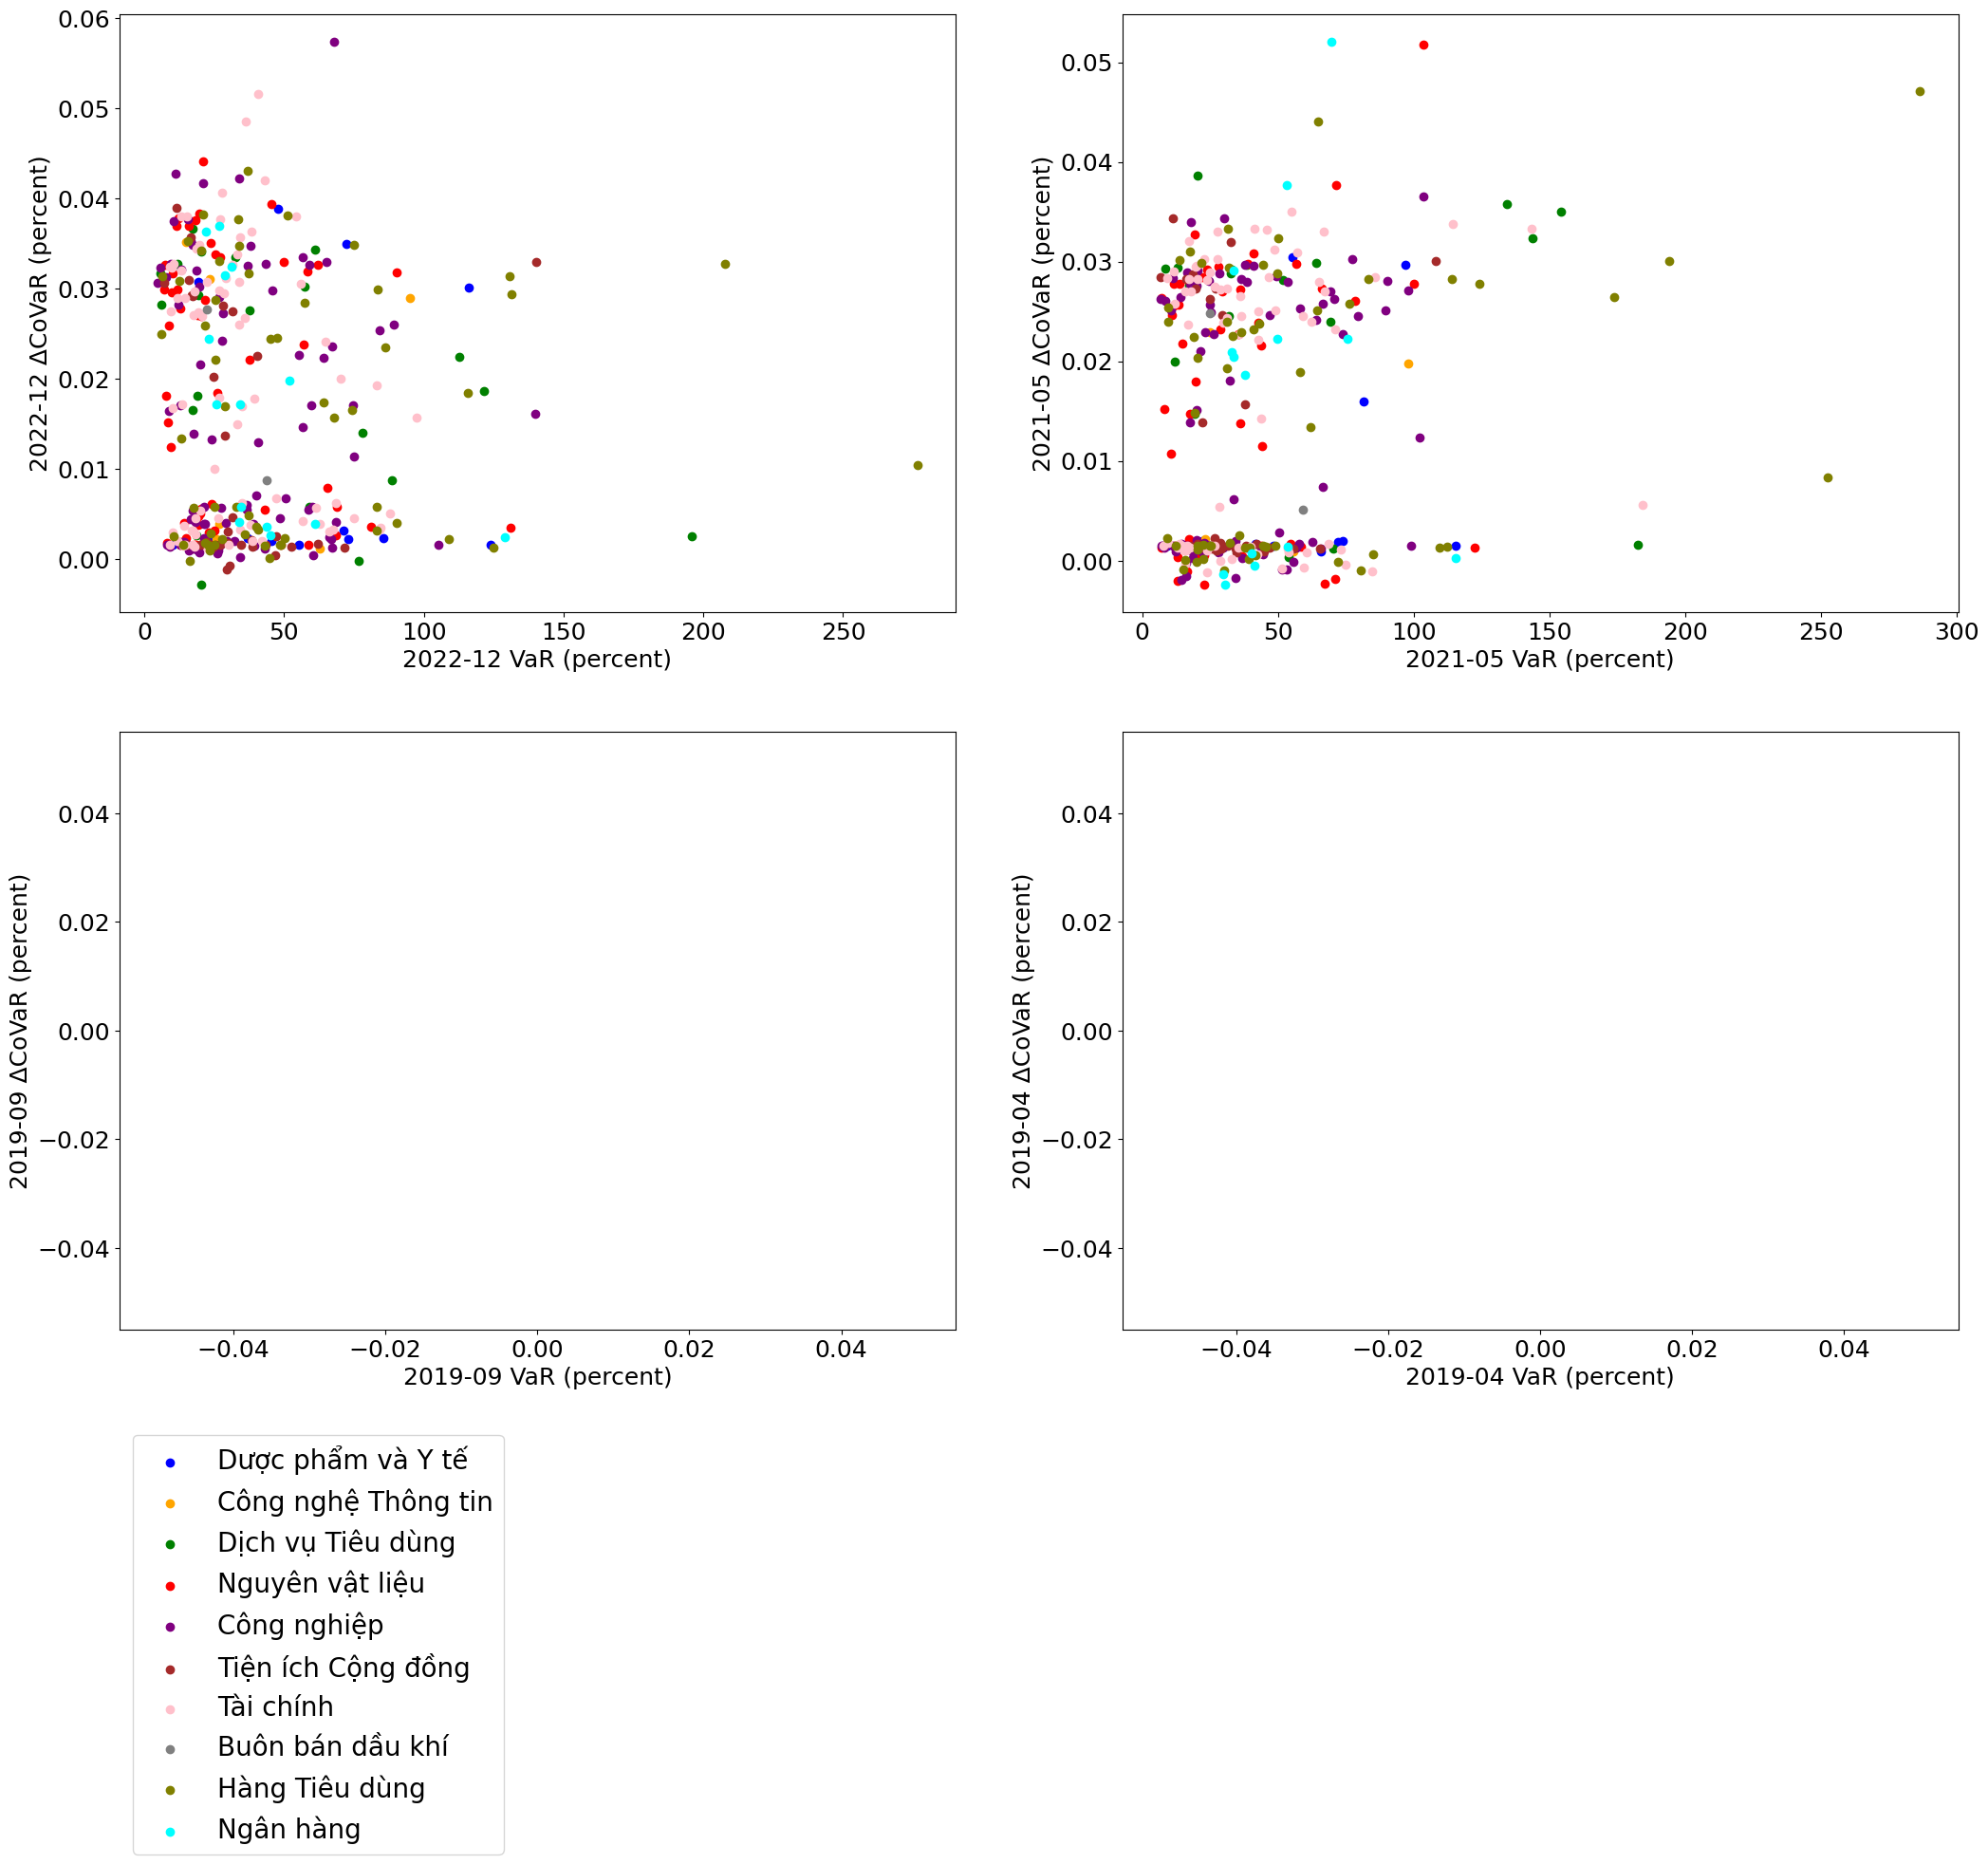

In [35]:
fig = plt.figure(figsize=(25, 18))
ax1 = fig.add_subplot(2, 2, 1)
sector_plot(ax1, 1, sector_analyze1)
ax2 = fig.add_subplot(2, 2, 2)
sector_plot(ax2, 20, sector_analyze2)
ax3 = fig.add_subplot(2, 2, 3)
sector_plot(ax3, 40, sector_analyze3, legend = True)
ax4 = fig.add_subplot(2, 2, 4)
sector_plot(ax4, 45, sector_analyze4)
